# MAE 271: Lab 1 - Quarter car simulation over bump
### Cooper Cook & Joshua Booth

![alt text](IMG_0967.jpg)


![alt text](IMG_0968.jpg)

The above graphics show the quarter car model with associated bond graph and descriptive equations for the system itself. The bump diagram is also drawn and the descriptive equations for that modeling are shown as well. 

The goal of the following lab project to follow is to analyze the above system for both linear and non-linear spring functions. As well as varying parameters of bump-height and car velocity to display the differences in responses to the spring characteristics in the system. 

Define global parameters and initial conditions for the system

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# -----------------------------
# Global Parameters
# -----------------------------
mt = 3500 / 2.2            # total mass [kg]
msmus = 5                 # sprung/unsprung mass ratio
mus = mt / (1 + msmus)    # unsprung mass [kg]
ms = mt - mus             # sprung mass [kg]

ks = ms * (2 * np.pi * 1)**2        # suspension stiffness
bs = 2 * 0.5 * np.sqrt(ks * ms)     # suspension damping
kt = mus * (2 * np.pi * 8)**2       # tire stiffness
g = 9.8                             # gravity [m/s^2]

# Road input parameters
#A = 2 * 0.0254          # bump height [m]
d = 3 * 0.3048          # bump length [m]
#u = 30 * 0.46           # vehicle speed [m/s]

# Nonlinear spring toggle
non_lin = 0
G = (ks / (3 * (ms * g)**(2/3)))**3

# Initial conditions: [ps, pus, qs, qt]
if non_lin == 1:
    initial = [0, 0, (ms * g / G)**(1/3), mt * g / kt]
else:
    initial = [0, 0, 1.0 * ms * g / ks, mt * g / kt]

# Time span
t_span = (0, 1)
t_eval = np.arange(0, 1.001, 0.001)

Run through the different parameters with the varying bump and speed

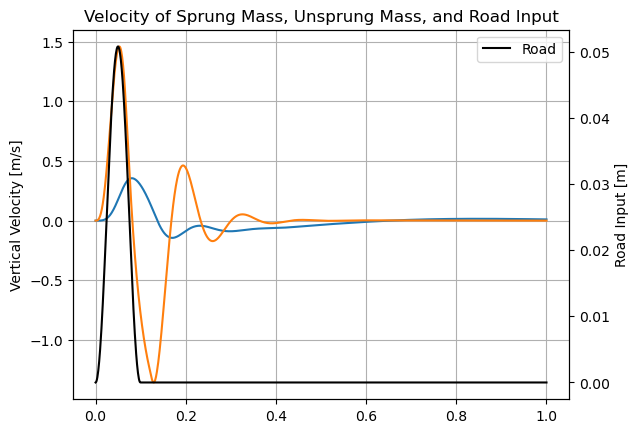

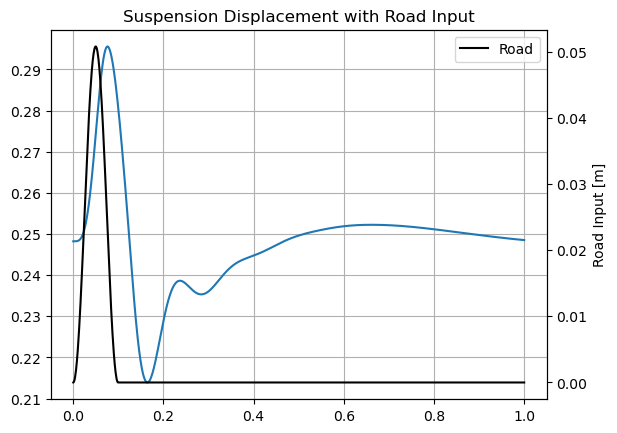

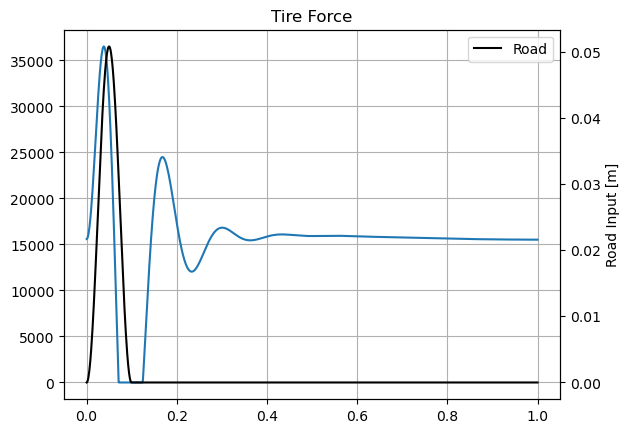

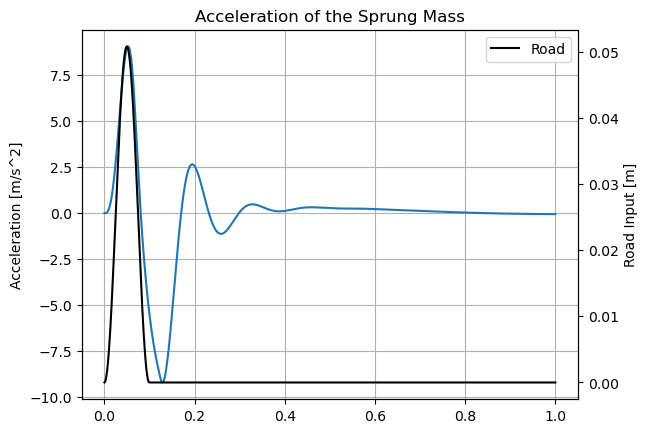

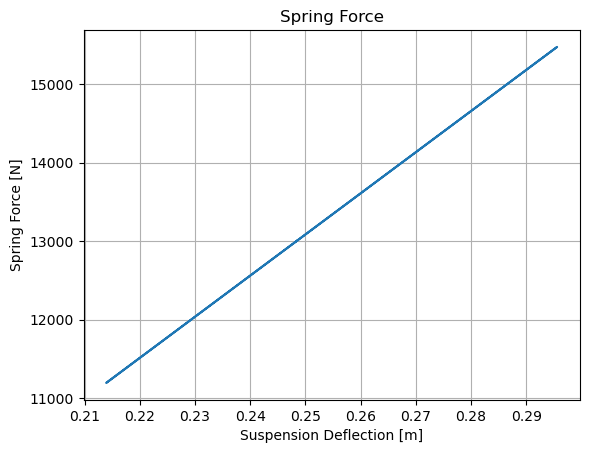

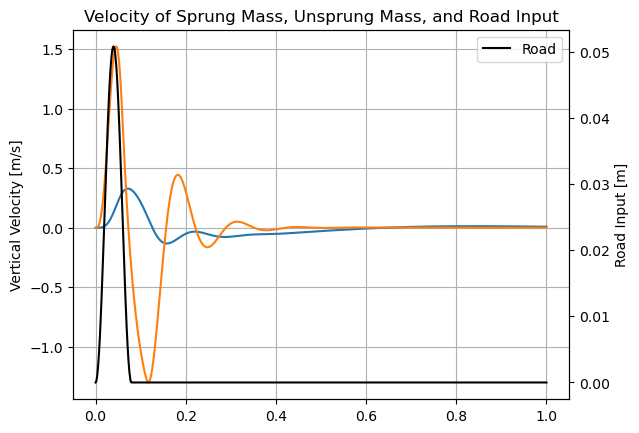

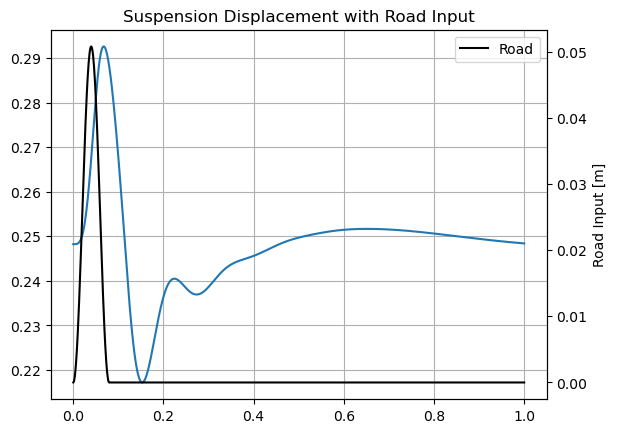

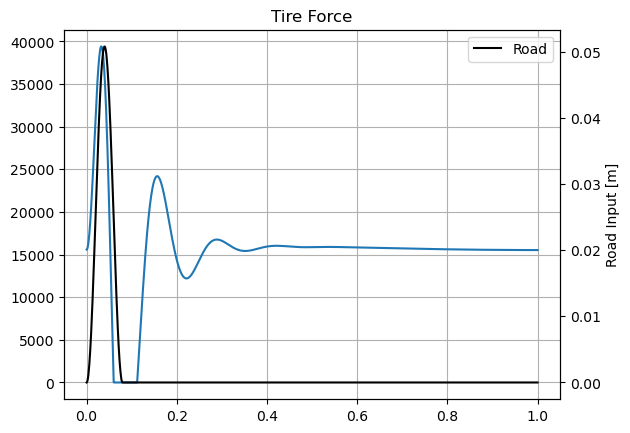

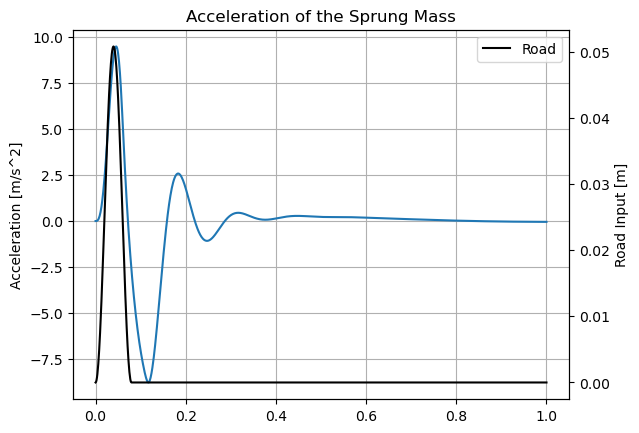

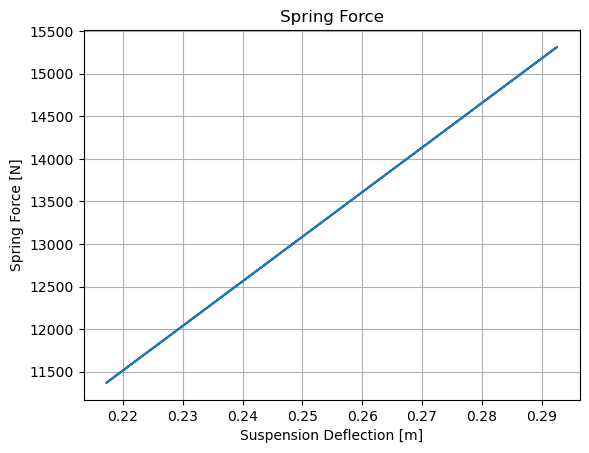

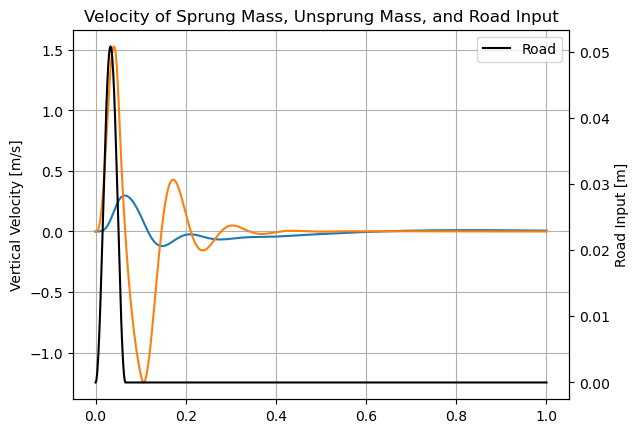

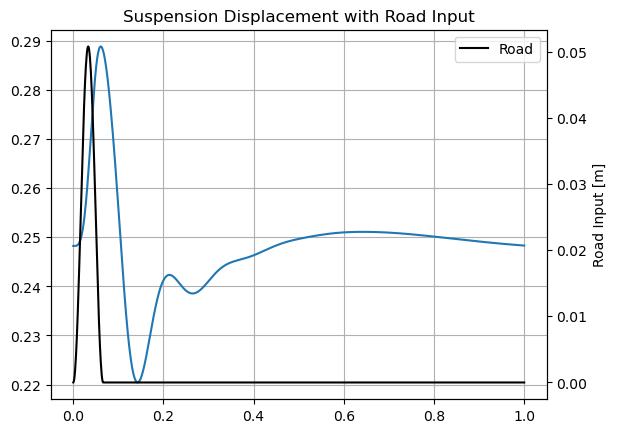

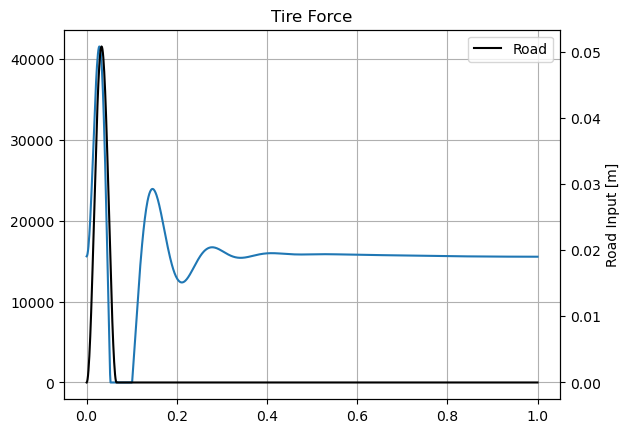

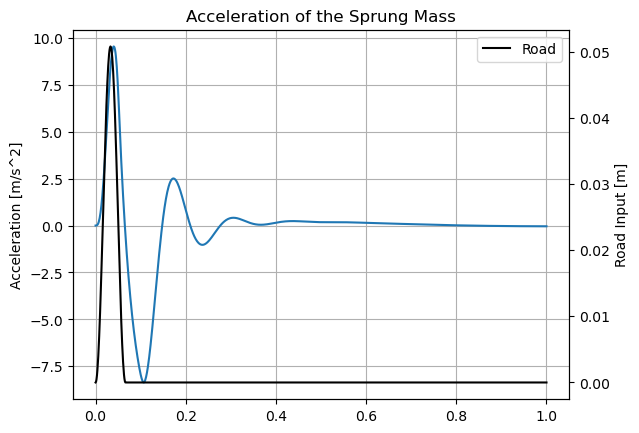

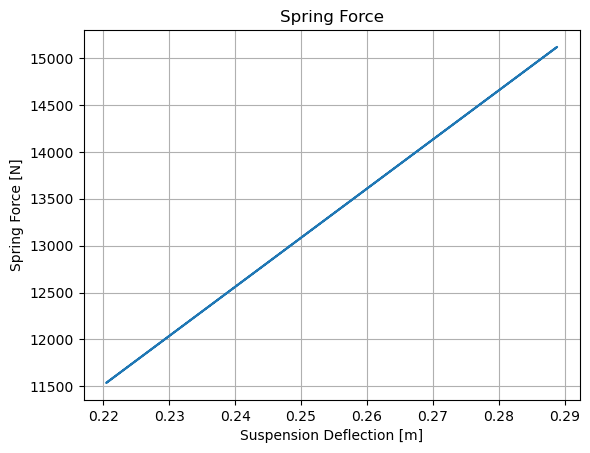

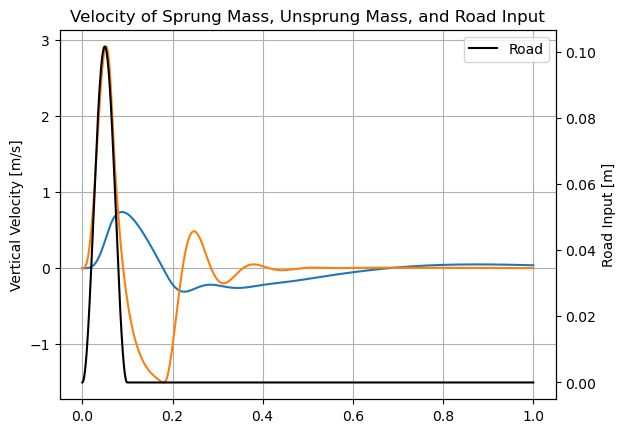

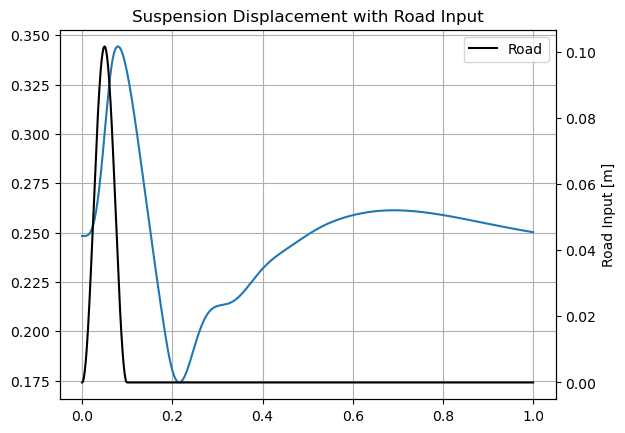

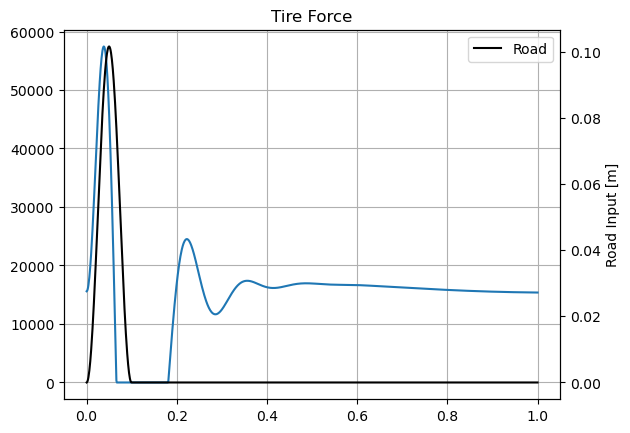

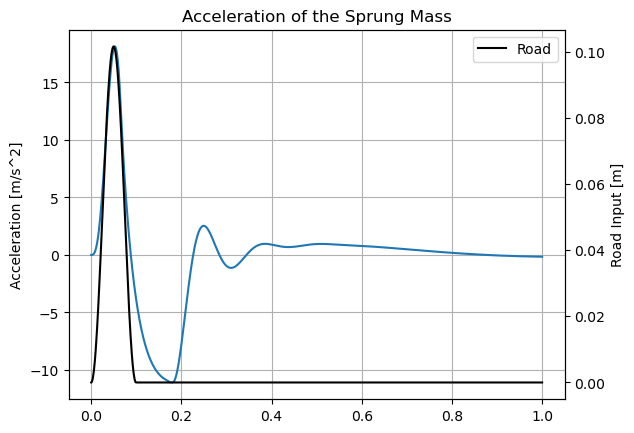

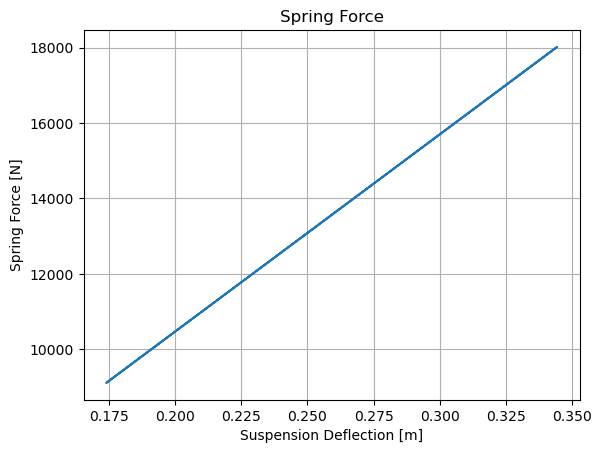

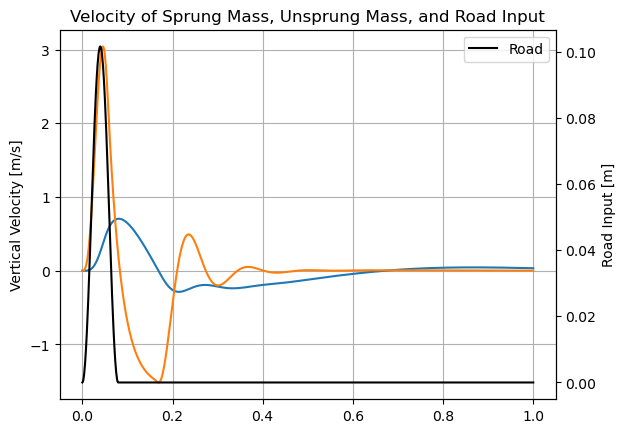

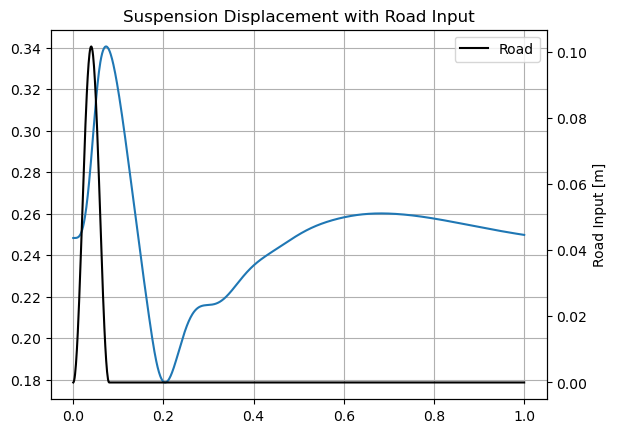

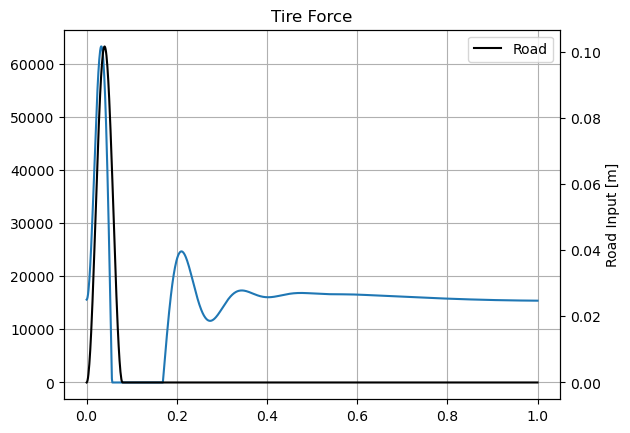

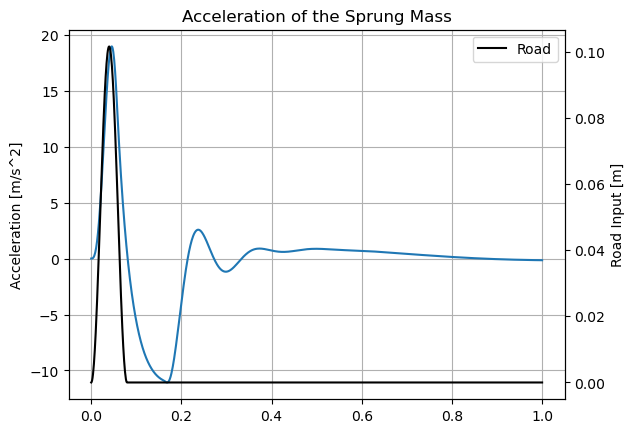

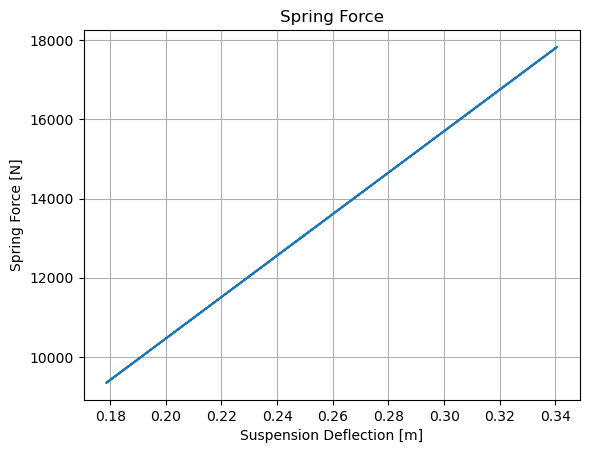

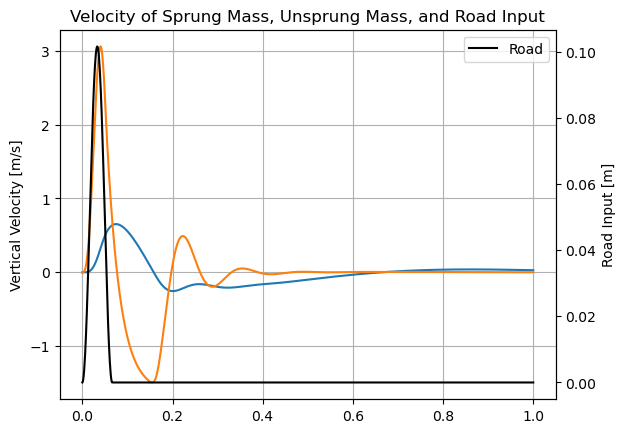

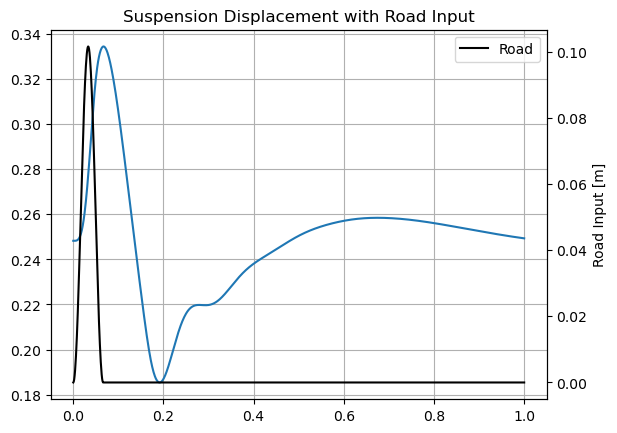

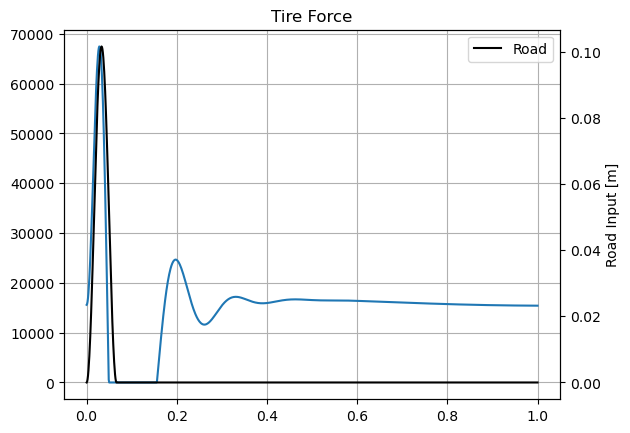

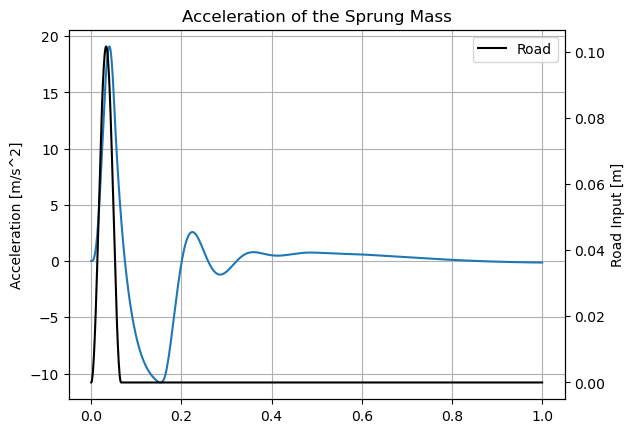

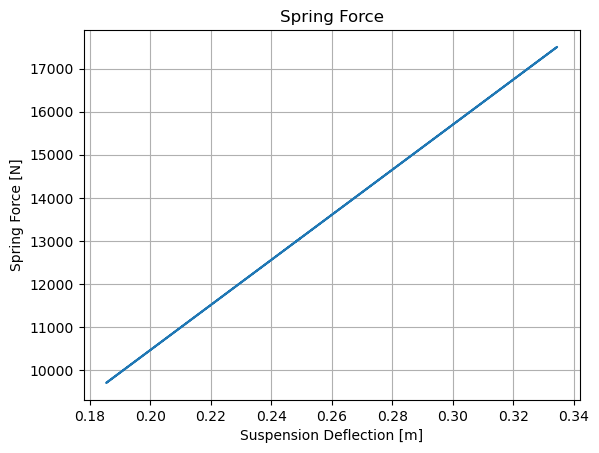

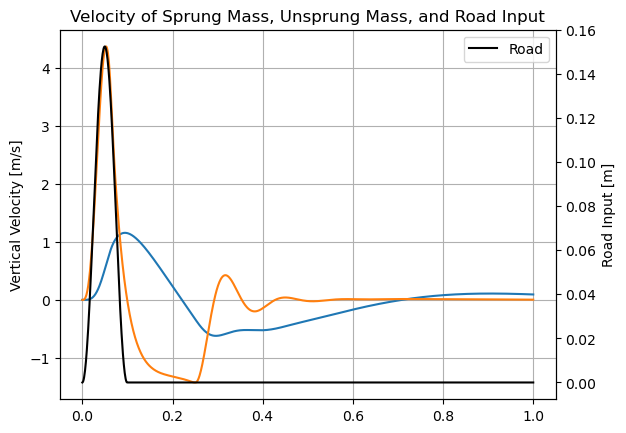

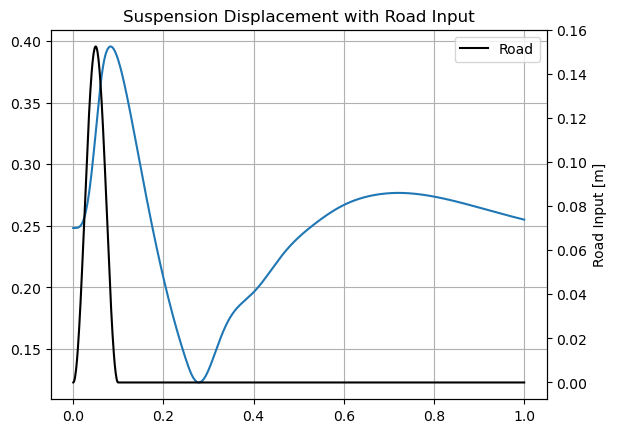

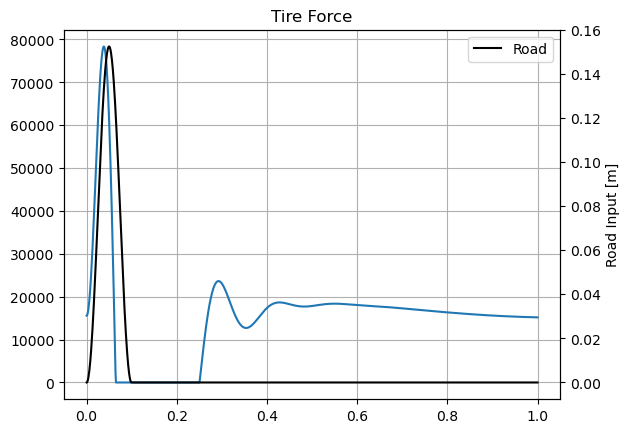

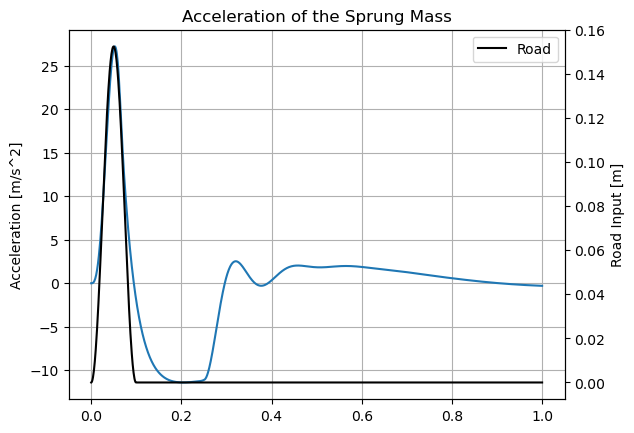

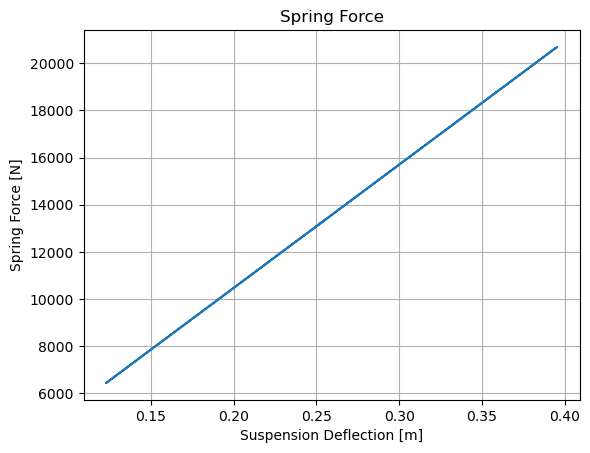

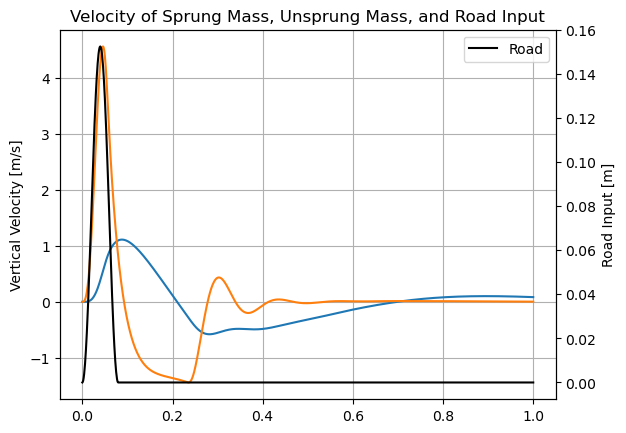

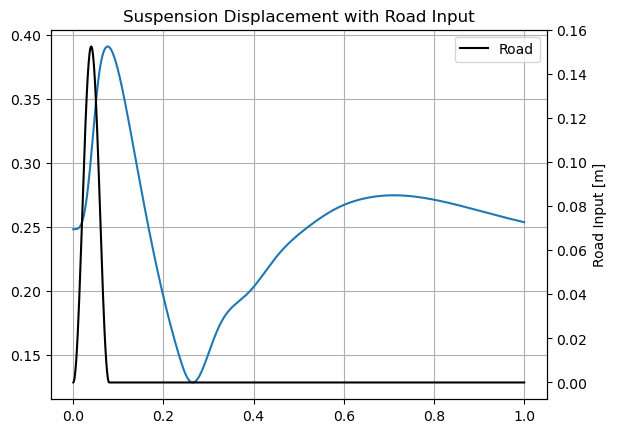

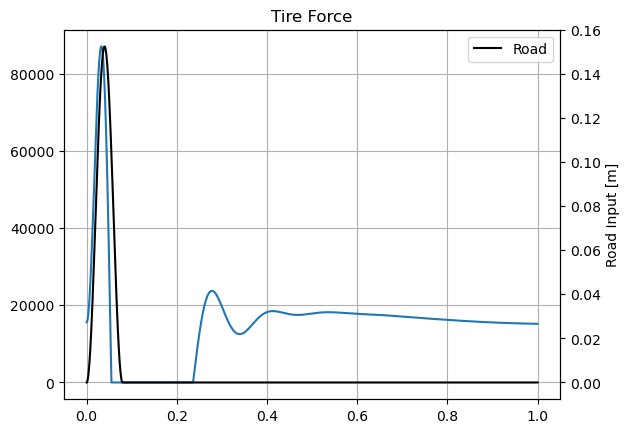

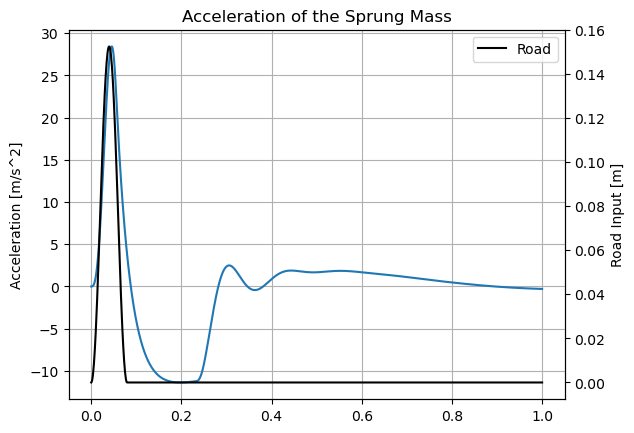

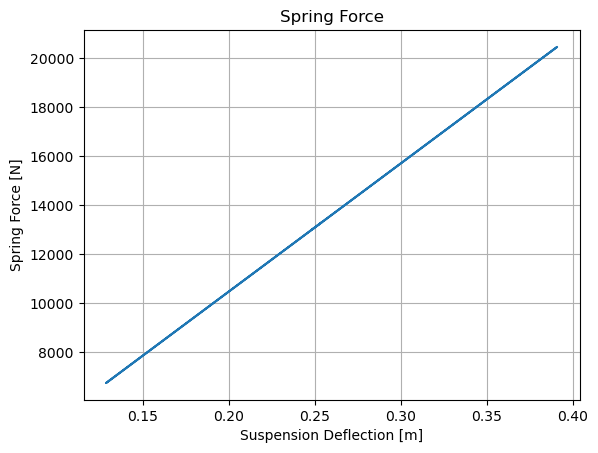

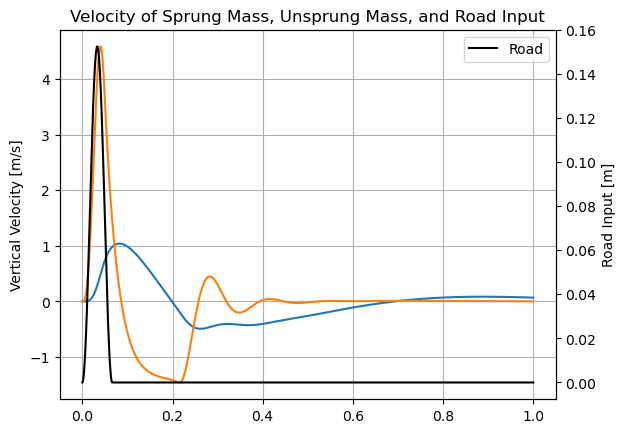

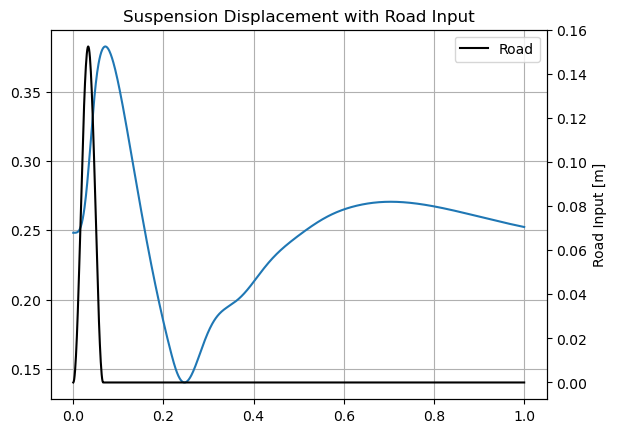

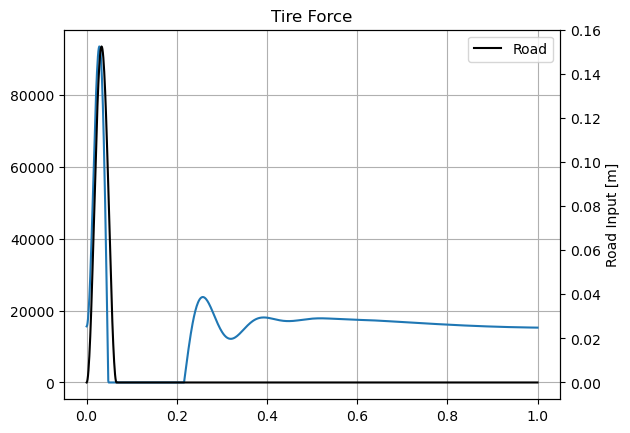

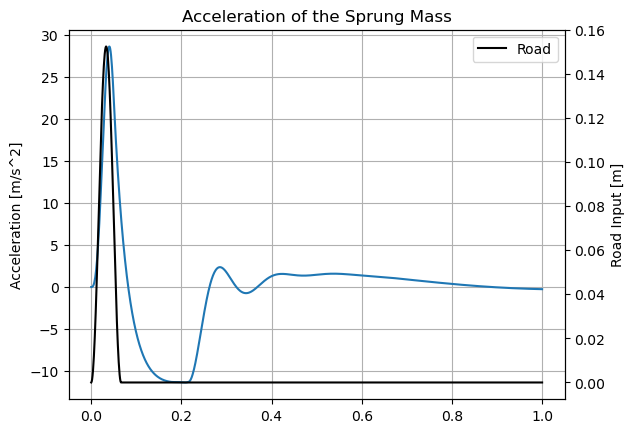

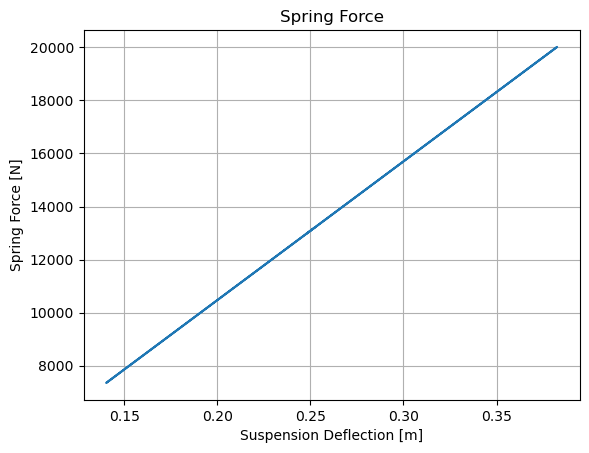

In [2]:
for A in [2*0.0254, 4*0.0254, 6*0.0254]:   # Loop through varying bump heights 
    for u in [20*0.46, 25*0.46, 30*0.46]:  # Loop through varying car speeds for each bump height
        # -----------------------------
        # Model Function
        # -----------------------------
        def LabDemoFunc(t, s):
            ps, pus, qs, qt = s

            # Road input
            X = u * t
            Y = 0.5 * A * (1 - np.cos(2 * np.pi * X / d))
            dYdX = 0.5 * A * (2 * np.pi / d) * np.sin(2 * np.pi * X / d)

            if X > d:
                Y = 0
                dYdX = 0

            vin = u * dYdX

            # Tire force
            Ft = kt * qt
            if qt <= 0:
                Ft = 0

            # Velocities
            vs = ps / ms
            vus = pus / mus

            # Spring force
            if non_lin == 1:
                Fs = G * qs**3 + bs * (vus - vs)
                Fss = G * qs**3
            else:
                Fs = ks * qs + bs * (vus - vs)
                Fss = ks * qs

            # State derivatives
            dps = -ms * g + Fs
            dpus = -mus * g + Ft - Fs
            dqs = vus - vs
            dqt = vin - vus

            ds = [dps, dpus, dqs, dqt]
            ext = [X, Y, Ft, vs, vus, vin, Fss]

            return ds, ext

        # Wrapper for solver
        def ode_wrapper(t, s):
            ds, _ = LabDemoFunc(t, s)
            return ds

        # -----------------------------
        # Run Simulation
        # -----------------------------
        sol = solve_ivp(ode_wrapper, t_span, initial, t_eval=t_eval)

        t = sol.t
        s = sol.y.T

        # Extract states
        ps, pus, qs, qt = s.T

        # Compute extra outputs
        ext = np.zeros((len(t), 7))
        ds = np.zeros((len(t), 4))

        for i in range(len(t)):
            ds[i], ext[i] = LabDemoFunc(t[i], s[i])

        dps, dpus, dqs, dqt = ds.T
        X, Y, Ft, vs, vus, vin, Fss = ext.T

        # -----------------------------
        # Plot Results
        # -----------------------------

        # Figure 1: Velocities + Road
        plt.figure(1)
        plt.plot(t, vs, label="Sprung Mass")
        plt.plot(t, vus, label="Unsprung Mass")
        plt.grid()
        plt.ylabel("Vertical Velocity [m/s]")
        #plt.ylim([-3, 3])

        plt.twinx()
        plt.plot(t, Y, label="Road", color="k")
        plt.ylabel("Road Input [m]")
        #plt.ylim([-0.15, 0.15])

        plt.title("Velocity of Sprung Mass, Unsprung Mass, and Road Input")
        plt.xlabel("Time [s]")
        plt.legend()
        plt.show()

        # Figure 2: Suspension Displacement
        plt.figure(2)
        plt.plot(t, qs, label="Suspension Displacement")
        plt.grid()

        plt.twinx()
        plt.plot(t, Y, label="Road", color="k")
        plt.ylabel("Road Input [m]")
        #plt.ylim([0, 0.15])

        plt.title("Suspension Displacement with Road Input")
        plt.xlabel("Time [s]")
        plt.legend()
        plt.show()

        # Figure 3: Tire Force
        plt.figure(3)
        plt.plot(t, Ft , label="Tire Force") # - Ft[0]
        plt.grid()

        plt.twinx()
        plt.plot(t, Y, label="Road", color="k")
        plt.ylabel("Road Input [m]")
        #plt.ylim([0, 0.15])

        plt.title("Tire Force")
        plt.xlabel("Time [s]")
        plt.legend()
        plt.show()

        # Figure 4: Sprung Mass Acceleration
        plt.figure(4)
        plt.plot(t, dps / ms, label="Acceleration")
        plt.grid()
        #plt.ylim([-19, 19])
        plt.ylabel("Acceleration [m/s^2]")

        plt.twinx()
        plt.plot(t, Y, label="Road", color="k")
        plt.ylabel("Road Input [m]")
        #plt.ylim([-0.15, 0.15])

        plt.title("Acceleration of the Sprung Mass")
        plt.xlabel("Time [s]")
        plt.legend()
        plt.show()

        # Figure 5: Spring Force vs Deflection
        plt.figure(5)
        plt.plot(qs, Fss)
        plt.grid()
        plt.title("Spring Force")
        plt.xlabel("Suspension Deflection [m]")
        plt.ylabel("Spring Force [N]")
        plt.show()
